In [ ]:
# prompt: mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
from rdkit import Chem

# Loading the dataset
data = pd.read_csv(r"/content/drive/MyDrive/Datasets/TYK2_final.csv")

# Function to check SMILES validity
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

# Applying the function to the SMILES column
data['valid'] = data['SMILES'].apply(is_valid_smiles)

# Count valid and invalid SMILES
valid_count = data['valid'].sum()
invalid_count = len(data) - valid_count

print(f"Valid SMILES: {valid_count}")
print(f"Invalid SMILES: {invalid_count}")

Valid SMILES: 9997
Invalid SMILES: 0


In [ ]:
unique_smiles = data['SMILES'].nunique()
print(f"Unique SMILES in the dataset: {unique_smiles}")

Unique SMILES in the dataset: 9997


In [ ]:
lengths = data['SMILES'].str.len()
print(f"Average length: {lengths.mean()}, Max length: {lengths.max()}")

Average length: 44.09092727818346, Max length: 57


In [ ]:
from collections import Counter
token_distribution = Counter("".join(data['SMILES']))
print("Token Distribution:", token_distribution)

Token Distribution: Counter({'c': 130104, 'C': 53549, '(': 50265, ')': 50265, 'N': 24565, 'O': 22200, '1': 19994, '2': 19994, '=': 17064, '3': 16882, 'n': 16197, 'F': 9073, 'l': 8516, '4': 646, '#': 309, 'B': 208, 'r': 208, 'o': 154, 'S': 138, '[': 137, 'H': 137, ']': 137, 's': 33, '5': 2})


In [ ]:
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Generate ECFP8b fingerprints
def generate_ecfp8b(smiles, radius=4, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))
    else:
        return np.zeros(n_bits)

# Apply fingerprint generation
data['ECFP8b'] = data['SMILES'].apply(generate_ecfp8b)

# Normalize affinity values
scaler = MinMaxScaler()
data['affinity_normalized'] = scaler.fit_transform(data['affinity'].values.reshape(-1, 1))

# Prepare features (X) and target (Y)
X = np.array(data['ECFP8b'].tolist())
Y = data['affinity_normalized'].values

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42)

# Print shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: ({Y_train.shape[0]}, None)")
print(f"X_test shape: {X_test.shape}, Y_test shape: ({Y_test.shape[0]}, None)")

Streaming output truncated to the last 5000 lines.
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:06:30] DEPRECATION WARNING: please use MorganGenerator
[06:0

X_train shape: (1999, 2048), Y_train shape: (1999, None)
X_test shape: (7998, 2048), Y_test shape: (7998, None)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Add
import tensorflow as tf

class LinearLayer(Layer):
    """
    Custom Linear Layer to follow KAN principles (no activation).
    """
    def __init__(self, output_dim):
        super(LinearLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        # Initialize weights and biases
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.output_dim),
            initializer='random_normal',
            trainable=True
        )
        self.bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        # Linear transformation: Wx + b
        return tf.matmul(inputs, self.kernel) + self.bias

def build_kan_model(input_dim):
    """
    Builds the Kolmogorov-Arnold Network (KAN)
    """
    inputs = Input(shape=(input_dim,))

    # Linear transformations
    layer1 = LinearLayer(input_dim)(inputs)
    layer2 = LinearLayer(input_dim)(layer1)

    # Additive Composition
    combined = Add()([layer1, layer2])

    # Output layer (Linear Transformation)
    outputs = LinearLayer(1)(combined)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_dim = X.shape[1]
kan_model = build_kan_model(input_dim)
kan_model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ linear_layer_123          │ (None, 2048)           │      4,196,352 │ input_layer_41[0][0]   │
│ (LinearLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ linear_layer_124          │ (None, 2048)           │      4,196,352 │ linear_layer_123[0][0] │
│ (LinearLayer)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_41 (Add)              │ (None, 2048)           │              0 │ linear_layer_123[0][0… │
│                           │                        │                │ linear_layer_124[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ linear_layer_125          │ (None, 1)              │          2,049 │ add_41[0][0]           │
│ (LinearLayer)             │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,394,753 (32.02 MB)

 Trainable params: 8,394,753 (32.02 MB)

 Non-trainable params: 0 (0.00 B)


Training on Fold 1...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 397.6656 - mae: 14.9581 - val_loss: 19.8422 - val_mae: 3.8679 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.4999 - mae: 2.6995 - val_loss: 0.8658 - val_mae: 0.7279 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0093 - mae: 0.7911 - val_loss: 0.2495 - val_mae: 0.3922 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1667 - mae: 0.3195 - val_loss: 0.0674 - val_mae: 0.2054 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0459 - mae: 0.1690 - val_loss: 0.0315 - val_mae: 0.1393 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0228 - mae: 0.1208 - val_loss: 0.0201 - val_mae: 0.1116 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - mae: 0.0912 - val_loss: 0.0162 - val_mae: 0.0960 - learni

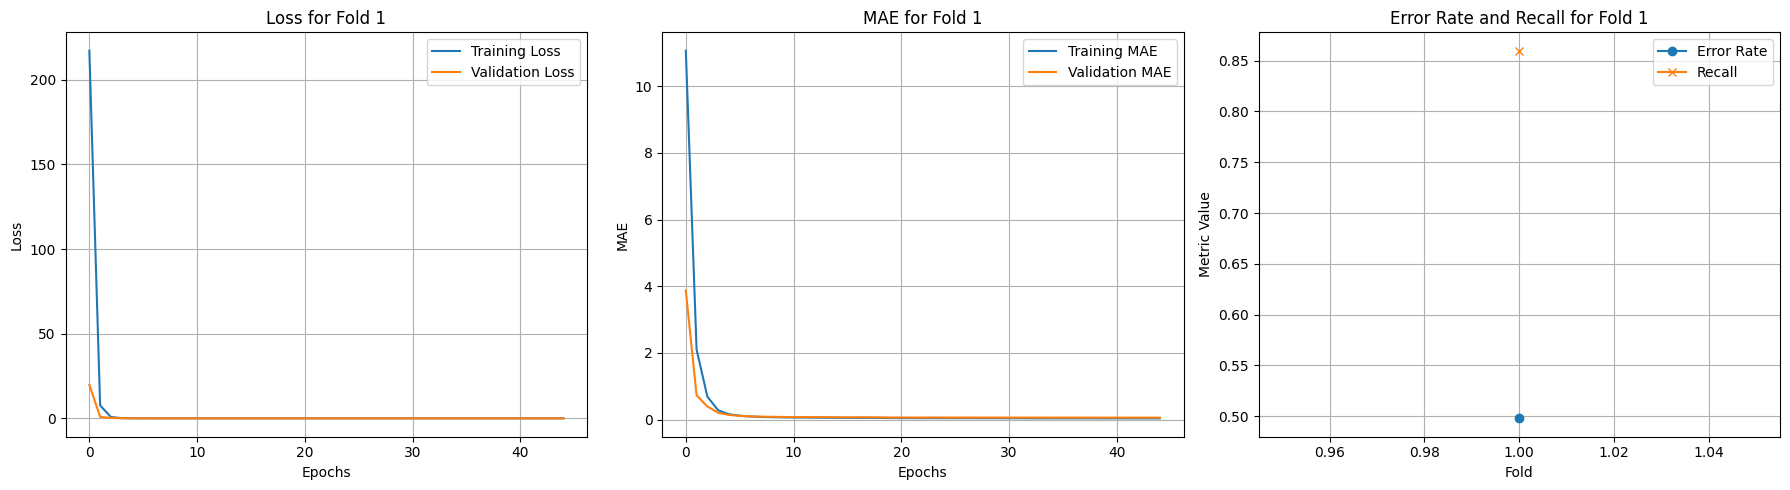


Training on Fold 2...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 319.6974 - mae: 13.0745 - val_loss: 16.7690 - val_mae: 3.3449 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.6270 - mae: 2.6249 - val_loss: 1.8925 - val_mae: 1.1113 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2324 - mae: 0.8695 - val_loss: 0.2060 - val_mae: 0.3664 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1638 - mae: 0.3150 - val_loss: 0.0576 - val_mae: 0.1932 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0409 - mae: 0.1586 - val_loss: 0.0252 - val_mae: 0.1259 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0167 - mae: 0.1015 - val_loss: 0.0169 - val_mae: 0.1009 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - mae: 0.0814 - val_loss: 0.0132 - val_mae: 0.0905 - learni

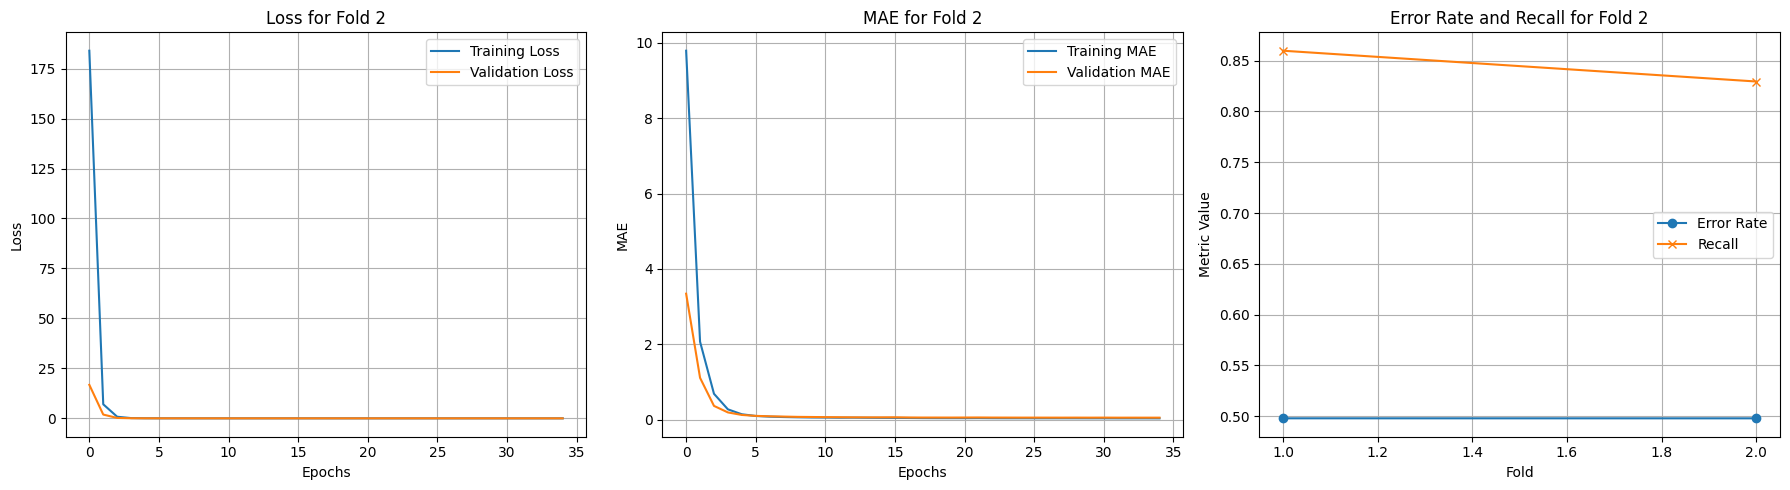


Training on Fold 3...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 169.1846 - mae: 9.1899 - val_loss: 20.4084 - val_mae: 3.6211 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9637 - mae: 2.3042 - val_loss: 1.6161 - val_mae: 1.0469 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8476 - mae: 0.7245 - val_loss: 0.2365 - val_mae: 0.3755 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1549 - mae: 0.3142 - val_loss: 0.0489 - val_mae: 0.1782 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0357 - mae: 0.1498 - val_loss: 0.0197 - val_mae: 0.1095 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - mae: 0.0861 - val_loss: 0.0138 - val_mae: 0.0888 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - mae: 0.0699 - val_loss: 0.0114 - val_mae: 0.0812 - learning

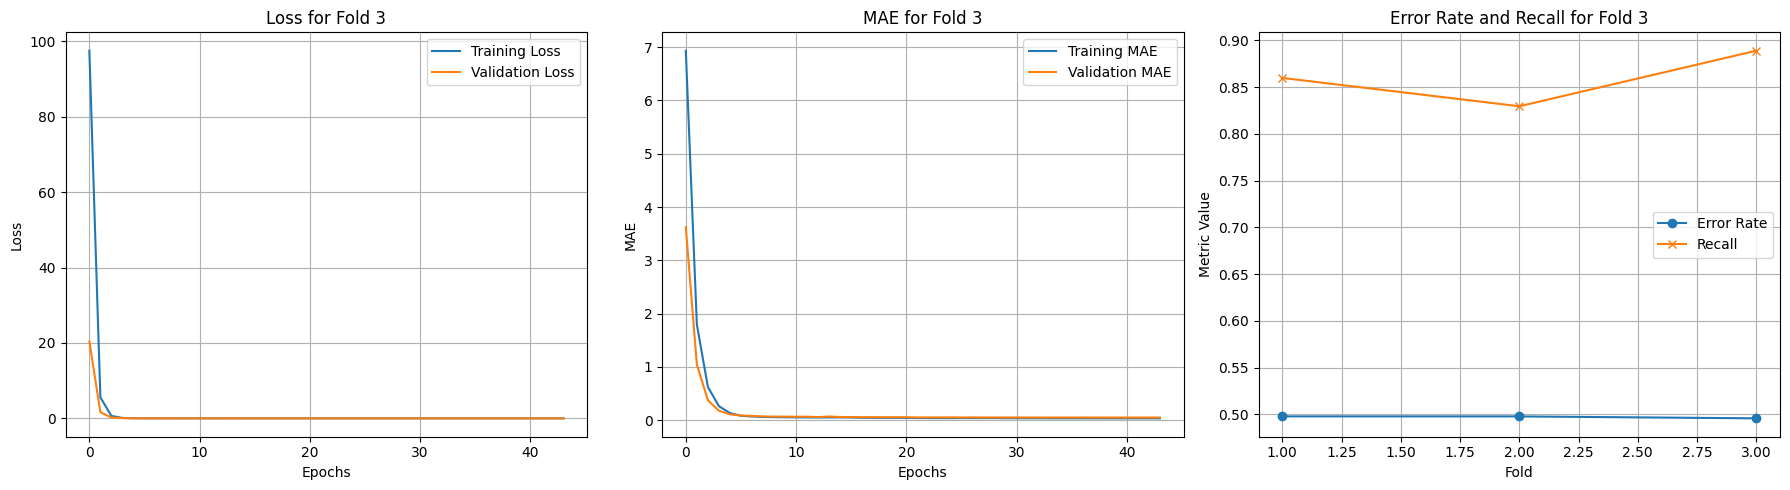


Training on Fold 4...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 399.7109 - mae: 14.8090 - val_loss: 16.8777 - val_mae: 3.3179 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.8120 - mae: 2.7888 - val_loss: 1.1811 - val_mae: 0.8839 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4394 - mae: 0.9225 - val_loss: 0.3062 - val_mae: 0.4385 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2169 - mae: 0.3729 - val_loss: 0.0934 - val_mae: 0.2437 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0597 - mae: 0.1903 - val_loss: 0.0455 - val_mae: 0.1710 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0299 - mae: 0.1337 - val_loss: 0.0249 - val_mae: 0.1195 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - mae: 0.0999 - val_loss: 0.0193 - val_mae: 0.1054 - learni

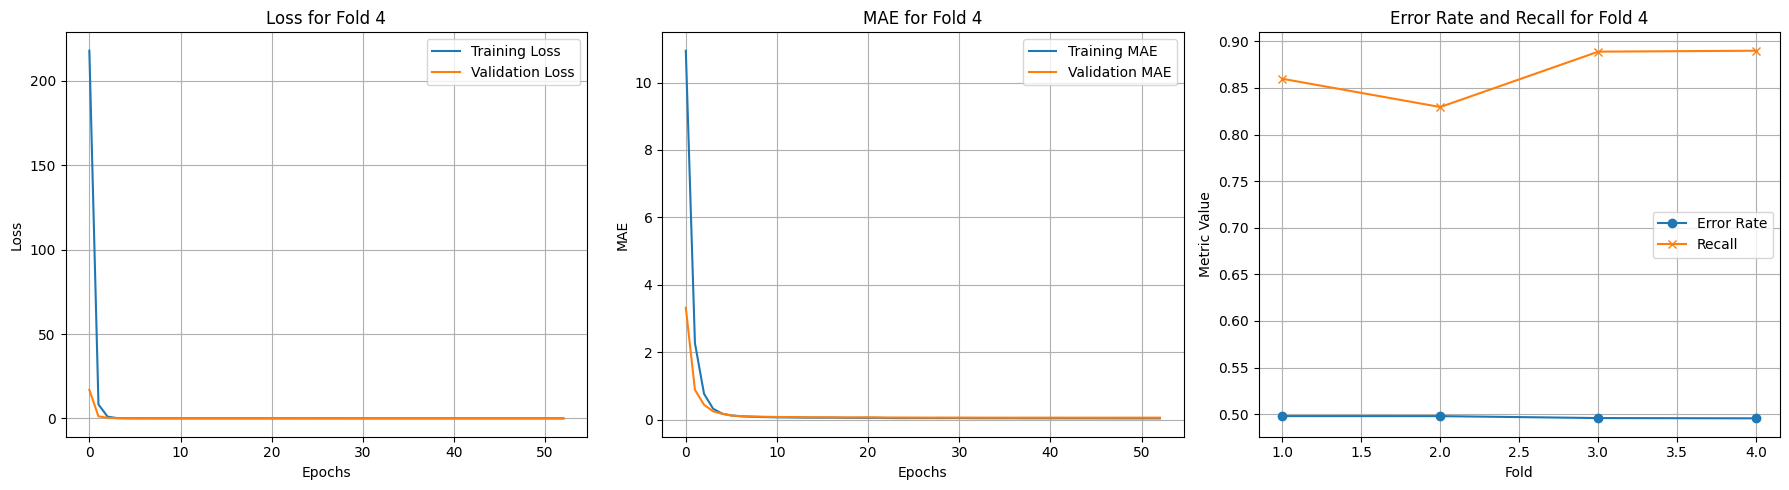


Training on Fold 5...
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 165.2888 - mae: 8.9714 - val_loss: 8.9690 - val_mae: 2.2965 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8069 - mae: 1.8909 - val_loss: 1.2430 - val_mae: 0.8945 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8091 - mae: 0.7016 - val_loss: 0.1909 - val_mae: 0.3460 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1313 - mae: 0.2827 - val_loss: 0.0458 - val_mae: 0.1641 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295 - mae: 0.1337 - val_loss: 0.0206 - val_mae: 0.1100 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - mae: 0.0873 - val_loss: 0.0142 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - mae: 0.0763 - val_loss: 0.0114 - val_mae: 0.0772 - learning_

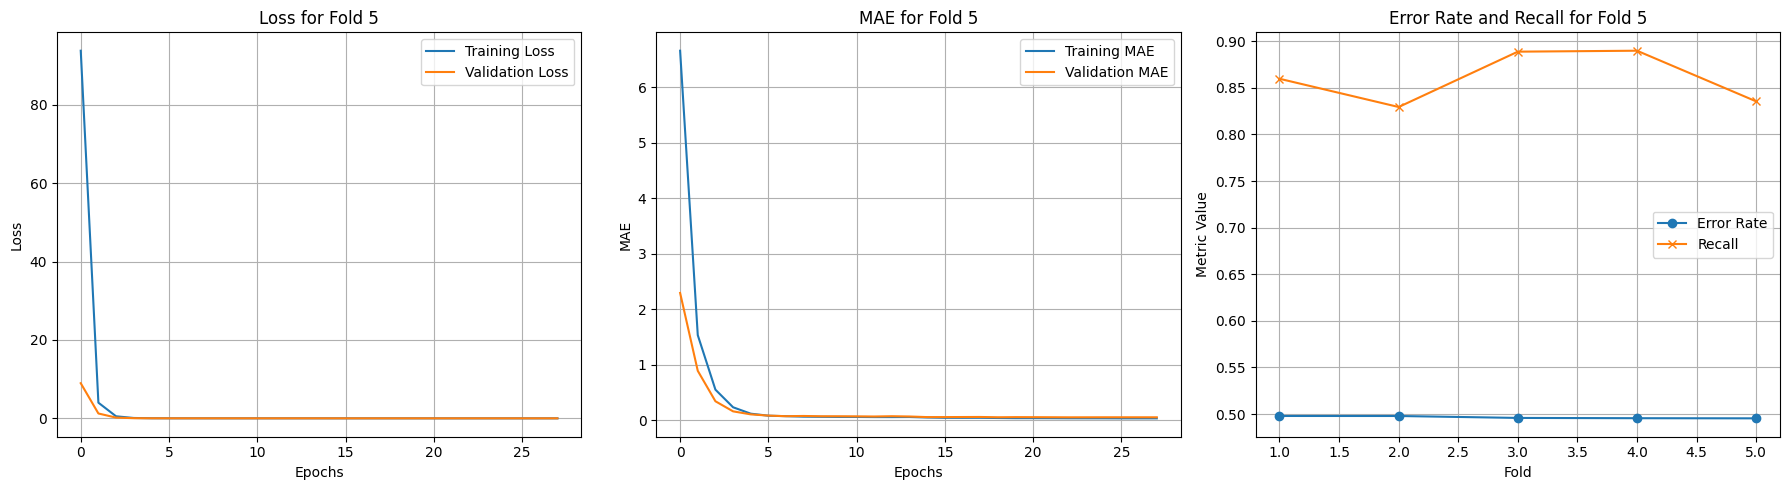

In [ ]:
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Initialize K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

error_rates = []
recalls = []

for train_idx, val_idx in kfold.split(X_train, Y_train):
    print(f"\nTraining on Fold {fold_no}...")

    # Split the data into training and validation sets
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    Y_fold_train, Y_fold_val = Y_train[train_idx], Y_train[val_idx]

    # Build the KAN model
    kan_model = build_kan_model(input_dim)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    # Train the model
    history = kan_model.fit(
        X_fold_train, Y_fold_train,
        validation_data=(X_fold_val, Y_fold_val),
        batch_size=64,
        epochs=100,
        verbose=1,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Calculate Error Rate and Recall
    Y_pred_val = kan_model.predict(X_fold_val)
    Y_pred_val_binary = (Y_pred_val > 0.5).astype(int)
    Y_val_binary = (Y_fold_val > 0.5).astype(int)

    recall = recall_score(Y_val_binary, Y_pred_val_binary)
    recalls.append(recall)

    error_rate = 1 - (Y_pred_val_binary == Y_val_binary).mean()
    error_rates.append(error_rate)

    # Extract final loss and MAE values
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]

    print(f"Fold {fold_no} - Training Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}")
    print(f"Fold {fold_no} - Training MAE: {final_train_mae:.4f}, Validation MAE: {final_val_mae:.4f}")
    print(f"Fold {fold_no} - Recall: {recall:.4f}, Error Rate: {error_rate:.4f}")

    # Plot Loss, MAE, and Error Rate/Recall
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title(f'Loss for Fold {fold_no}')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    # Plot MAE
    axes[1].plot(history.history['mae'], label='Training MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_title(f'MAE for Fold {fold_no}')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid()

    # Plot Error Rate and Recall
    axes[2].plot(range(1, fold_no + 1), error_rates, label='Error Rate', marker='o')
    axes[2].plot(range(1, fold_no + 1), recalls, label='Recall', marker='x')
    axes[2].set_title(f'Error Rate and Recall for Fold {fold_no}')
    axes[2].set_xlabel('Fold')
    axes[2].set_ylabel('Metric Value')
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout()
    plt.show()

    fold_no += 1

In [ ]:
# Predict on the test set
Y_pred_test = kan_model.predict(X_test)
Y_pred_test_binary = (Y_pred_test > 0.5).astype(int)
Y_test_binary = (Y_test > 0.5).astype(int)

# Calculate metrics manually
test_loss = tf.keras.losses.MeanSquaredError()(Y_test, Y_pred_test).numpy()
test_mae = tf.keras.metrics.MeanAbsoluteError()(Y_test, Y_pred_test).numpy()
accuracy = accuracy_score(Y_test_binary, Y_pred_test_binary)
error_rate = 1 - accuracy
recall = recall_score(Y_test_binary, Y_pred_test_binary)

# Print all metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Loss: 0.0078
Test MAE: 0.0589
Test Recall: 0.8630
Test Error Rate: 0.1577


In [ ]:
# Predict example SMILES affinity
example_smiles = "CC(C)C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2"
example_ecfp8b = generate_ecfp8b(example_smiles).reshape(1, -1)
predicted_affinity = kan_model.predict(example_ecfp8b)
original_affinity = scaler.inverse_transform(predicted_affinity)
print(f"Predicted Affinity: {original_affinity[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Affinity: 4.557602882385254


[06:08:00] DEPRECATION WARNING: please use MorganGenerator
